# Brain Tumor Classification - Inference

This notebook loads a trained brain tumor classification model and makes predictions on individual images.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
from skimage import exposure
from skimage.morphology import binary_closing, binary_opening, disk

## 2. Define Model Architecture

In [2]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

## 3. Image Preprocessing Functions (Same as mask.ipynb)

In [3]:
def adjust_gamma(image, gamma=1.0):
    """Adjust gamma of the image."""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(image, table)

def correct_bias_field(image):
    """Approximate bias field correction using local contrast enhancement."""
    img_float = image.astype(np.float32) / 255.0
    bias_field = cv2.GaussianBlur(img_float, (99, 99), 0)
    bias_field = np.maximum(bias_field, 0.01)
    corrected = img_float / bias_field
    corrected = exposure.rescale_intensity(corrected, out_range=(0, 1))
    corrected = (corrected * 255).astype(np.uint8)
    return corrected

def preprocess_image(image):
    """Preprocess the image with improved bias correction and contrast enhancement."""
    image_float = image.astype(float)
    image_norm = (image_float - image_float.min()) / (image_float.max() - image_float.min())
    image_norm = (image_norm * 255).astype(np.uint8)
    image_bias_corrected = correct_bias_field(image_norm)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_clahe = clahe.apply(image_bias_corrected)
    image_gamma = adjust_gamma(image_clahe, gamma=1.2)
    image_denoised = cv2.fastNlMeansDenoising(image_gamma)
    return image_denoised

def create_brain_mask(image):
    """Create a binary mask for brain region with improved skull removal and boundary smoothing."""
    image = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    selem_main = disk(5)
    mask = binary_closing(binary_opening(binary > 0, selem_main), selem_main)
    mask = (mask * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    kernel_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.erode(mask, kernel_erode, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_smooth)
    return mask

def apply_mask(image, mask):
    """Apply the mask to the original image with improved edge handling."""
    if image.shape != mask.shape:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    kernel_edge = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    edge_mask = cv2.dilate(mask, kernel_edge, iterations=1)
    inner_mask = cv2.erode(mask, kernel_edge, iterations=1)
    edge_zone = cv2.subtract(edge_mask, inner_mask)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    edge_pixels = cv2.bitwise_and(image, image, mask=edge_zone)
    edge_pixels = cv2.GaussianBlur(edge_pixels, (3,3), 0)
    
    final_image = cv2.add(
        cv2.bitwise_and(masked_image, masked_image, mask=cv2.bitwise_not(edge_zone)),
        edge_pixels
    )
    return final_image

## 4. Load Trained Model

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = 'brain_tumor_classifier_v1.pth'
checkpoint = torch.load(model_path, map_location=device)

# Extract model info
class_names = checkpoint['model_config']['class_names']
num_classes = checkpoint['model_config']['num_classes']
image_size = checkpoint['preprocessing']['input_size']

print(f"\nModel Information:")
print(f"- Number of classes: {num_classes}")
print(f"- Classes: {class_names}")
print(f"- Input size: {image_size}x{image_size}")
print(f"- Best validation accuracy: {checkpoint['performance']['best_val_accuracy']:.4f}")

# Create model and load weights
model = BrainTumorCNN(num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("\n✓ Model loaded successfully!")

Using device: cuda

Model Information:
- Number of classes: 4
- Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
- Input size: 128x128
- Best validation accuracy: 0.9635

✓ Model loaded successfully!


C:\Users\Jatin\AppData\Local\Temp\ipykernel_33164\1321960664.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


## 5. Define Prediction Function

In [5]:
def predict_image(image_path, apply_masking=True):
    """
    Predict the class of a brain MRI image.
    
    Args:
        image_path: Path to the image file
        apply_masking: Whether to apply brain masking preprocessing
    
    Returns:
        predicted_class: The predicted class name
        confidence: Confidence score (0-100)
        probabilities: Dictionary of all class probabilities
    """
    # Load image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Convert to grayscale
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    
    # Apply masking if requested
    if apply_masking:
        preprocessed = preprocess_image(img_gray)
        mask = create_brain_mask(preprocessed)
        masked = apply_mask(preprocessed, mask)
        # Convert back to RGB
        img_processed = cv2.cvtColor(masked, cv2.COLOR_GRAY2RGB)
    else:
        img_processed = img
    
    # Convert to PIL and apply transforms
    img_pil = Image.fromarray(img_processed)
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=checkpoint['preprocessing']['mean'],
            std=checkpoint['preprocessing']['std']
        )
    ])
    
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100
    
    # Get all class probabilities
    all_probs = {class_names[i]: probabilities[0][i].item() * 100 
                 for i in range(num_classes)}
    
    return predicted_class, confidence_score, all_probs

## 6. Visualize Prediction

In [6]:
def visualize_prediction(image_path, predicted_class, confidence, all_probs):
    """Visualize the image with prediction results."""
    # Load and display image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display image
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Display probability bar chart
    classes = list(all_probs.keys())
    probs = list(all_probs.values())
    colors = ['green' if c == predicted_class else 'lightblue' for c in classes]
    
    ax2.barh(classes, probs, color=colors)
    ax2.set_xlabel('Probability (%)', fontsize=12)
    ax2.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    
    # Add percentage labels
    for i, (c, p) in enumerate(zip(classes, probs)):
        ax2.text(p + 1, i, f'{p:.2f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## 7. Test on Single Image

Provide the path to a brain MRI image to classify.


Prediction Results
Predicted Class: notumor
Confidence: 99.97%

All Class Probabilities:
  notumor: 99.97%
  meningioma: 0.03%
  pituitary: 0.00%
  glioma: 0.00%



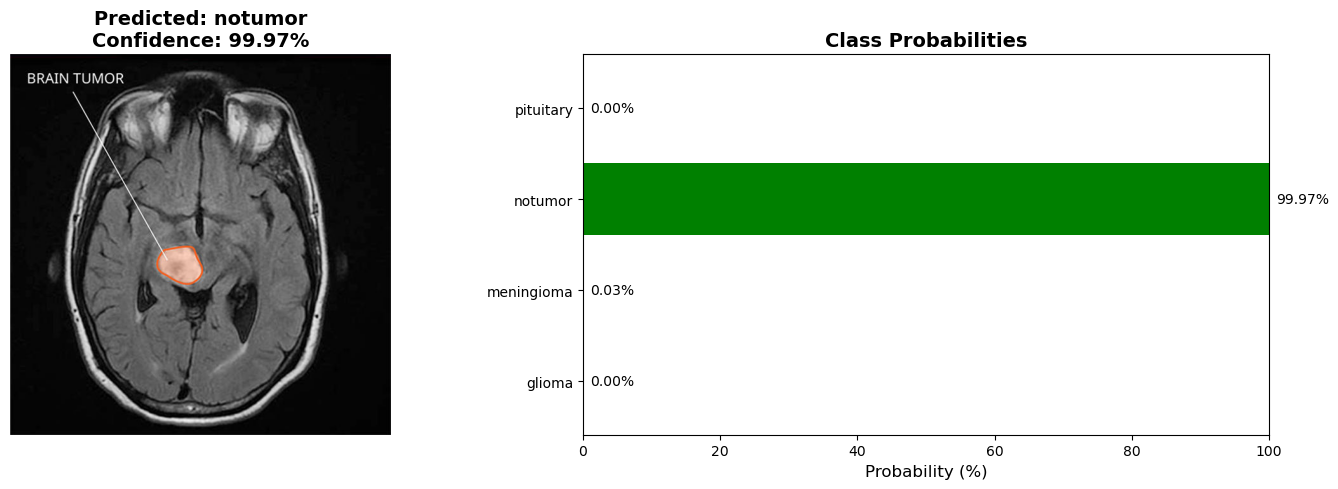

In [7]:
# Specify the path to your test image
test_image_path = 'g4.jpg'

# Make prediction
predicted_class, confidence, all_probs = predict_image(test_image_path, apply_masking=True)

# Display results
print(f"\n{'='*50}")
print(f"Prediction Results")
print(f"{'='*50}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")
print(f"\nAll Class Probabilities:")
for class_name, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
    print(f"  {class_name}: {prob:.2f}%")
print(f"{'='*50}\n")

# Visualize
visualize_prediction(test_image_path, predicted_class, confidence, all_probs)

## 8. Test on Multiple Images from a Directory

In [27]:
def predict_directory(directory_path, max_images=10, apply_masking=True):
    """
    Predict classes for all images in a directory.
    
    Args:
        directory_path: Path to directory containing images
        max_images: Maximum number of images to process
        apply_masking: Whether to apply brain masking preprocessing
    """
    directory = Path(directory_path)
    image_files = list(directory.glob('*.jpg')) + list(directory.glob('*.png'))
    
    if not image_files:
        print(f"No images found in {directory_path}")
        return
    
    # Limit number of images
    image_files = image_files[:max_images]
    
    print(f"Processing {len(image_files)} images from {directory_path}\n")
    
    results = []
    for img_path in image_files:
        try:
            predicted_class, confidence, all_probs = predict_image(img_path, apply_masking)
            results.append({
                'image': img_path.name,
                'predicted': predicted_class,
                'confidence': confidence
            })
            print(f"✓ {img_path.name}: {predicted_class} ({confidence:.2f}%)")
        except Exception as e:
            print(f"✗ {img_path.name}: Error - {str(e)}")
    
    return results

# Example: Test on a directory
test_directory = r'C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Test\glioma'
results = predict_directory(test_directory, max_images=5)

Processing 5 images from C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Test\glioma

✓ Te-glTr_0000.jpg: glioma (99.98%)
✓ Te-glTr_0001.jpg: glioma (100.00%)
✓ Te-glTr_0001.jpg: glioma (100.00%)
✓ Te-glTr_0002.jpg: glioma (100.00%)
✓ Te-glTr_0003.jpg: glioma (76.78%)
✓ Te-glTr_0002.jpg: glioma (100.00%)
✓ Te-glTr_0003.jpg: glioma (76.78%)
✓ Te-glTr_0004.jpg: meningioma (62.46%)
✓ Te-glTr_0004.jpg: meningioma (62.46%)


## 9. Visualize Multiple Predictions

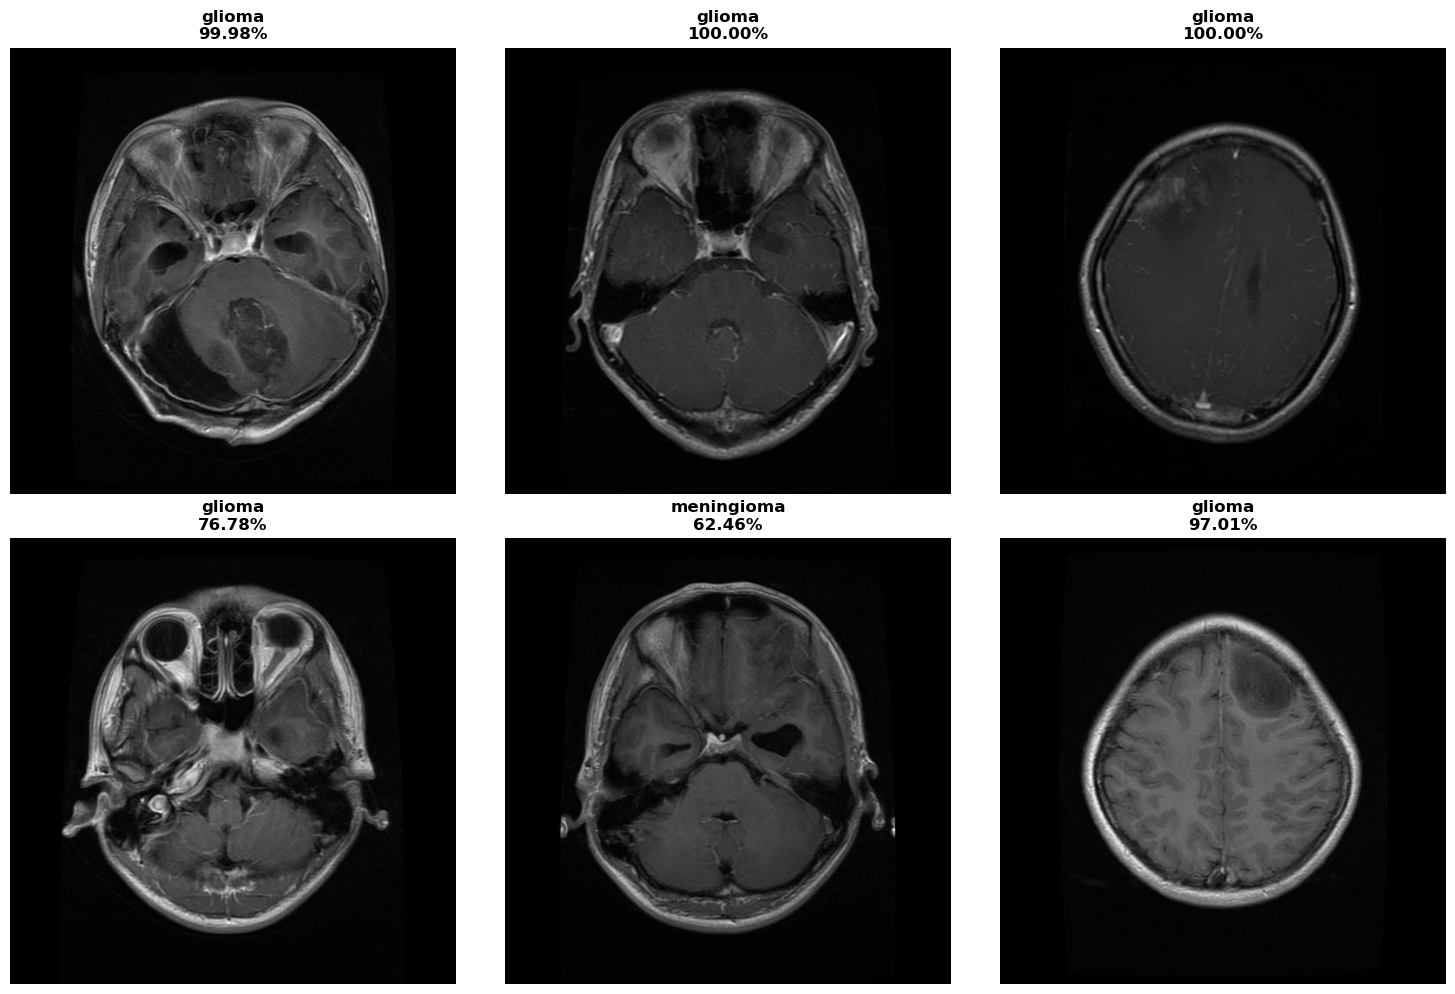

In [28]:
def visualize_multiple_predictions(directory_path, num_images=6, apply_masking=True):
    """Visualize predictions for multiple images in a grid."""
    directory = Path(directory_path)
    image_files = list(directory.glob('*.jpg')) + list(directory.glob('*.png'))
    image_files = image_files[:num_images]
    
    rows = (num_images + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for idx, img_path in enumerate(image_files):
        try:
            predicted_class, confidence, _ = predict_image(img_path, apply_masking)
            
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img)
            axes[idx].set_title(f'{predicted_class}\n{confidence:.2f}%', 
                              fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(image_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize multiple predictions
visualize_multiple_predictions(test_directory, num_images=6)

## 10. Diagnostic Test - Compare Transforms

Let's test if there are any issues with the model predictions and compare different preprocessing approaches.

In [5]:
def diagnostic_test(image_path):
    """
    Run comprehensive diagnostic tests to identify potential issues.
    Compares:
    1. Prediction with masking (current approach)
    2. Prediction without masking
    3. Check if augmentation would help (spoiler: it shouldn't for inference)
    """
    print("="*70)
    print("DIAGNOSTIC TEST - BRAIN TUMOR CLASSIFICATION")
    print("="*70)
    
    # Load original image
    img_original = cv2.imread(str(image_path))
    if img_original is None:
        print(f"ERROR: Could not load image: {image_path}")
        return
    
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    
    # TEST 1: With masking preprocessing (as in app.py)
    print("\n[TEST 1] Prediction WITH masking preprocessing:")
    preprocessed = preprocess_image(img_gray)
    mask = create_brain_mask(preprocessed)
    masked = apply_mask(preprocessed, mask)
    img_masked_rgb = cv2.cvtColor(masked, cv2.COLOR_GRAY2RGB)
    img_pil_masked = Image.fromarray(img_masked_rgb)
    
    transform_inference = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=checkpoint['preprocessing']['mean'],
            std=checkpoint['preprocessing']['std']
        )
    ])
    
    img_tensor_masked = transform_inference(img_pil_masked).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs_masked = model(img_tensor_masked)
        probs_masked = torch.nn.functional.softmax(outputs_masked, dim=1)
        conf_masked, pred_masked = torch.max(probs_masked, 1)
    
    print(f"  Predicted: {class_names[pred_masked.item()]}")
    print(f"  Confidence: {conf_masked.item() * 100:.2f}%")
    print(f"  All probabilities:")
    for i, name in enumerate(class_names):
        print(f"    {name}: {probs_masked[0][i].item() * 100:.2f}%")
    
    # TEST 2: Without masking (raw image)
    print("\n[TEST 2] Prediction WITHOUT masking preprocessing:")
    img_pil_raw = Image.fromarray(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    img_tensor_raw = transform_inference(img_pil_raw).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs_raw = model(img_tensor_raw)
        probs_raw = torch.nn.functional.softmax(outputs_raw, dim=1)
        conf_raw, pred_raw = torch.max(probs_raw, 1)
    
    print(f"  Predicted: {class_names[pred_raw.item()]}")
    print(f"  Confidence: {conf_raw.item() * 100:.2f}%")
    print(f"  All probabilities:")
    for i, name in enumerate(class_names):
        print(f"    {name}: {probs_raw[0][i].item() * 100:.2f}%")
    
    # TEST 3: Check model uncertainty
    print("\n[TEST 3] Model Uncertainty Analysis:")
    entropy_masked = -torch.sum(probs_masked * torch.log(probs_masked + 1e-10), dim=1).item()
    entropy_raw = -torch.sum(probs_raw * torch.log(probs_raw + 1e-10), dim=1).item()
    
    max_entropy = -np.log(1.0 / len(class_names))  # Maximum possible entropy
    
    print(f"  Entropy (with masking): {entropy_masked:.4f} / {max_entropy:.4f}")
    print(f"  Entropy (without masking): {entropy_raw:.4f} / {max_entropy:.4f}")
    print(f"  Lower entropy = more confident prediction")
    
    if entropy_masked > 1.0:
        print("  ⚠️  HIGH UNCERTAINTY - Model is not confident!")
    elif entropy_masked > 0.5:
        print("  ⚠️  MODERATE UNCERTAINTY - Model is somewhat uncertain")
    else:
        print("  ✓ LOW UNCERTAINTY - Model is confident")
    
    # TEST 4: Check if predictions match
    print("\n[TEST 4] Consistency Check:")
    if pred_masked.item() == pred_raw.item():
        print(f"  ✓ CONSISTENT: Both approaches predict '{class_names[pred_masked.item()]}'")
    else:
        print(f"  ✗ INCONSISTENT:")
        print(f"    With masking: {class_names[pred_masked.item()]}")
        print(f"    Without masking: {class_names[pred_raw.item()]}")
        print("  This suggests the masking preprocessing might be too aggressive!")
    
    # VISUALIZATION
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Images
    axes[0, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(preprocessed, cmap='gray')
    axes[0, 1].set_title('After Preprocessing\n(Bias Correction + CLAHE)', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(masked, cmap='gray')
    axes[0, 2].set_title('After Masking', fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Probability distributions
    classes = class_names
    probs_m = probs_masked[0].cpu().numpy() * 100
    probs_r = probs_raw[0].cpu().numpy() * 100
    
    x_pos = np.arange(len(classes))
    
    axes[1, 0].barh(x_pos, probs_m, color=['green' if i == pred_masked.item() else 'lightblue' for i in range(len(classes))])
    axes[1, 0].set_yticks(x_pos)
    axes[1, 0].set_yticklabels(classes)
    axes[1, 0].set_xlabel('Probability (%)', fontsize=12)
    axes[1, 0].set_title(f'Probabilities WITH Masking\n{class_names[pred_masked.item()]} ({conf_masked.item()*100:.1f}%)', 
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlim(0, 100)
    for i, p in enumerate(probs_m):
        axes[1, 0].text(p + 1, i, f'{p:.1f}%', va='center')
    
    axes[1, 1].barh(x_pos, probs_r, color=['green' if i == pred_raw.item() else 'lightblue' for i in range(len(classes))])
    axes[1, 1].set_yticks(x_pos)
    axes[1, 1].set_yticklabels(classes)
    axes[1, 1].set_xlabel('Probability (%)', fontsize=12)
    axes[1, 1].set_title(f'Probabilities WITHOUT Masking\n{class_names[pred_raw.item()]} ({conf_raw.item()*100:.1f}%)', 
                        fontsize=14, fontweight='bold')
    axes[1, 1].set_xlim(0, 100)
    for i, p in enumerate(probs_r):
        axes[1, 1].text(p + 1, i, f'{p:.1f}%', va='center')
    
    # Comparison bar chart
    width = 0.35
    axes[1, 2].bar(x_pos - width/2, probs_m, width, label='With Masking', alpha=0.8)
    axes[1, 2].bar(x_pos + width/2, probs_r, width, label='Without Masking', alpha=0.8)
    axes[1, 2].set_ylabel('Probability (%)', fontsize=12)
    axes[1, 2].set_xlabel('Class', fontsize=12)
    axes[1, 2].set_title('Comparison', fontsize=14, fontweight='bold')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(classes, rotation=45, ha='right')
    axes[1, 2].legend()
    axes[1, 2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # SUMMARY
    print("\n" + "="*70)
    print("DIAGNOSTIC SUMMARY")
    print("="*70)
    print(f"Model Validation Accuracy: {checkpoint['performance']['best_val_accuracy']:.2%}")
    print(f"Prediction Consistency: {'✓ PASS' if pred_masked.item() == pred_raw.item() else '✗ FAIL'}")
    print(f"Confidence Level: {'High' if conf_masked.item() > 0.8 else 'Medium' if conf_masked.item() > 0.5 else 'Low'}")
    
    if entropy_masked > 1.0:
        print("\n⚠️  ISSUE DETECTED:")
        print("   High entropy indicates the model is uncertain about this prediction.")
        print("   Possible causes:")
        print("   1. Image quality is poor")
        print("   2. Image is not similar to training data")
        print("   3. Model needs more training or better data")
    elif pred_masked.item() != pred_raw.item():
        print("\n⚠️  ISSUE DETECTED:")
        print("   Inconsistent predictions with/without masking.")
        print("   This suggests the preprocessing might be too aggressive.")
        print("   Consider:")
        print("   1. Reducing CLAHE intensity")
        print("   2. Using less aggressive masking")
        print("   3. Training with both masked and unmasked images")
    else:
        print("\n✓ NO MAJOR ISSUES DETECTED")
        print("   Model is performing as expected!")
    
    print("="*70)

# Test with an image
test_img = 'g4.jpg'  # Change this to your test image path
if Path(test_img).exists():
    diagnostic_test(test_img)
else:
    print(f"Image not found: {test_img}")
    print("Please update the path to a valid image file.")

Image not found: g4.jpg
Please update the path to a valid image file.


DIAGNOSTIC TEST - BRAIN TUMOR CLASSIFICATION

[TEST 1] Prediction WITH masking preprocessing:
  Predicted: glioma
  Confidence: 97.87%
  All probabilities:
    glioma: 97.87%
    meningioma: 1.69%
    notumor: 0.44%
    pituitary: 0.00%

[TEST 2] Prediction WITHOUT masking preprocessing:
  Predicted: glioma
  Confidence: 100.00%
  All probabilities:
    glioma: 100.00%
    meningioma: 0.00%
    notumor: 0.00%
    pituitary: 0.00%

[TEST 3] Model Uncertainty Analysis:
  Entropy (with masking): 0.1140 / 1.3863
  Entropy (without masking): 0.0001 / 1.3863
  Lower entropy = more confident prediction
  ✓ LOW UNCERTAINTY - Model is confident

[TEST 4] Consistency Check:
  ✓ CONSISTENT: Both approaches predict 'glioma'


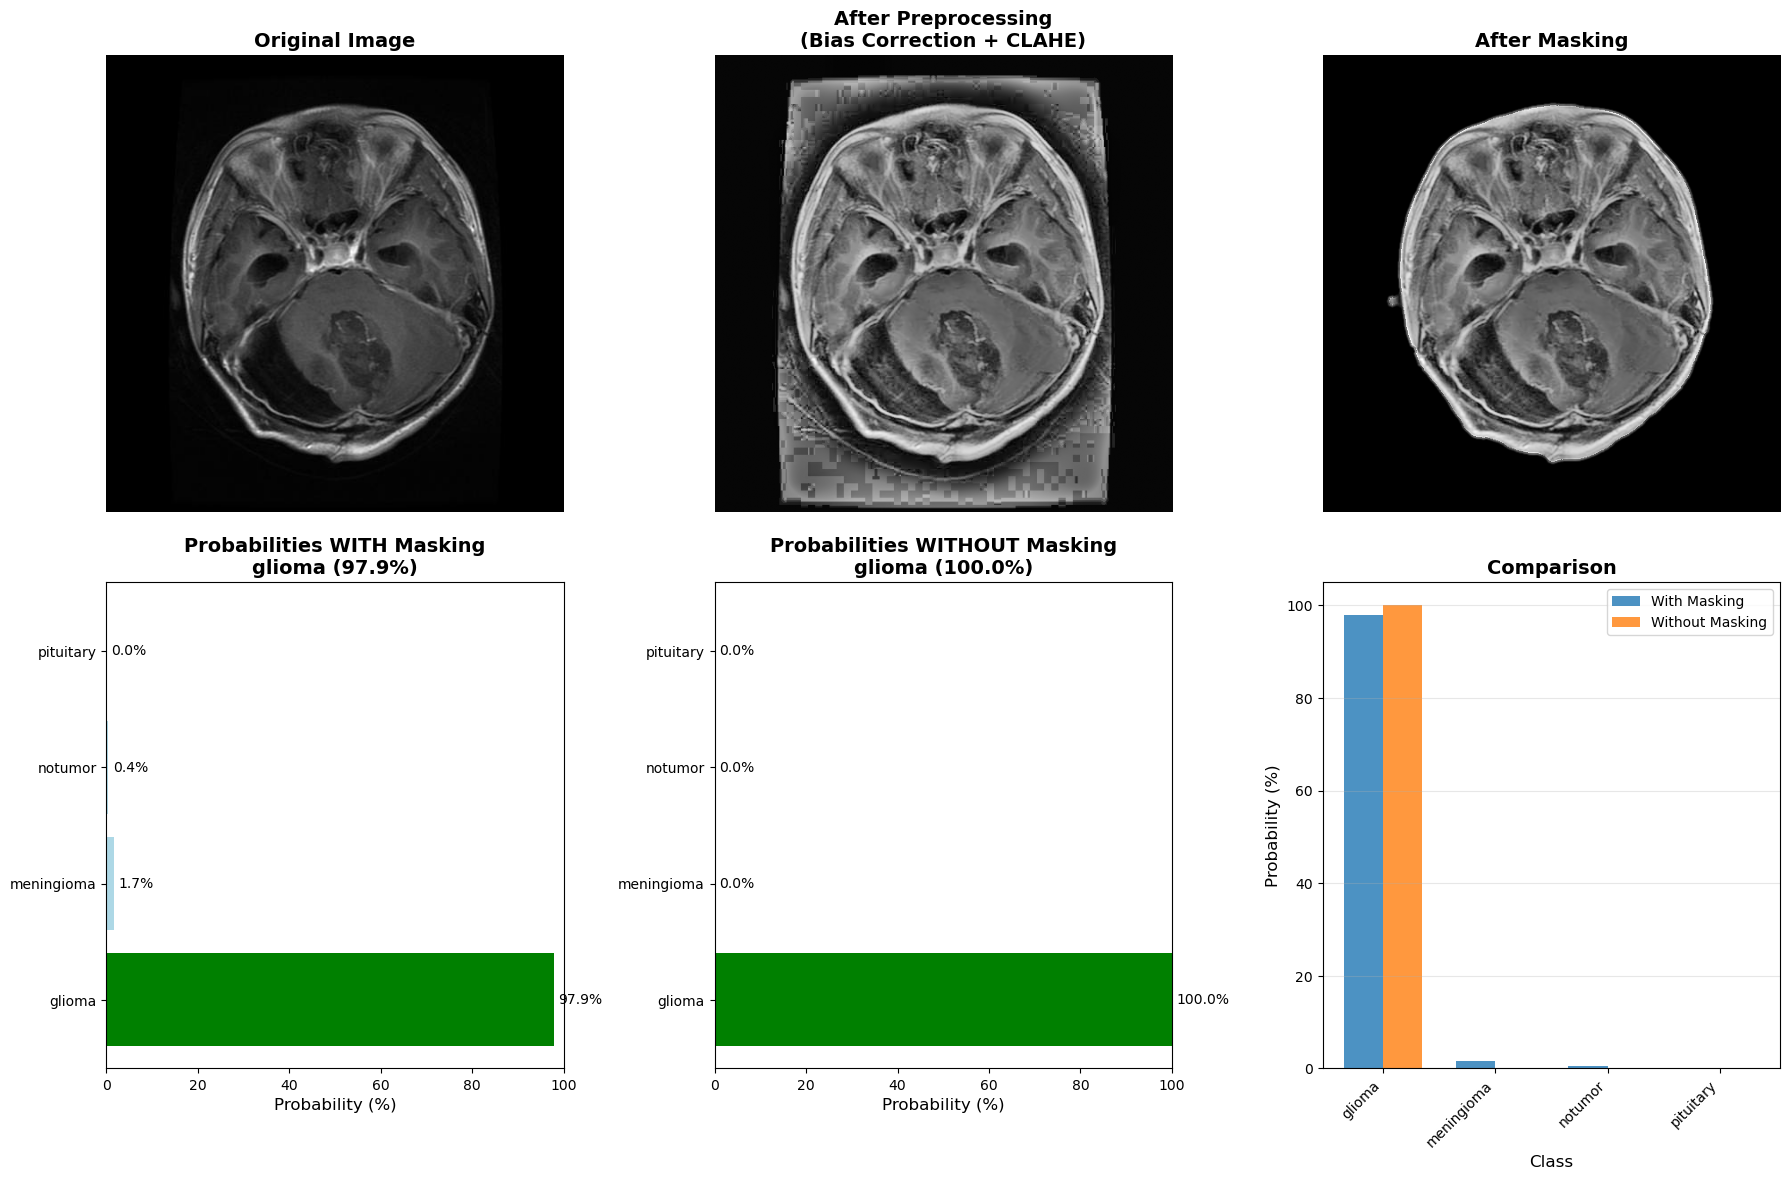


DIAGNOSTIC SUMMARY
Model Validation Accuracy: 96.35%
Prediction Consistency: ✓ PASS
Confidence Level: High

✓ NO MAJOR ISSUES DETECTED
   Model is performing as expected!


In [6]:
# Run diagnostic test on a real test image
test_image_path = r'C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Test\glioma\Te-glTr_0000.jpg'

if Path(test_image_path).exists():
    diagnostic_test(test_image_path)
else:
    print(f"❌ Image not found: {test_image_path}")

## 11. Batch Performance Test

Let's test the model on multiple images from each class to verify overall performance.

In [8]:
def batch_performance_test(test_dir, num_samples_per_class=10):
    """
    Test model performance across all classes.
    """
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix
    
    test_path = Path(test_dir)
    
    results = {
        'correct': 0,
        'total': 0,
        'per_class': {}
    }
    
    print("="*70)
    print("BATCH PERFORMANCE TEST")
    print("="*70)
    
    # Test each class
    for class_name in class_names:
        class_dir = test_path / class_name
        if not class_dir.exists():
            print(f"⚠️  Directory not found: {class_dir}")
            continue
        
        image_files = list(class_dir.glob('*.jpg'))[:num_samples_per_class]
        
        if not image_files:
            print(f"⚠️  No images found in {class_dir}")
            continue
        
        results['per_class'][class_name] = {
            'correct': 0,
            'total': len(image_files),
            'predictions': []
        }
        
        print(f"\nTesting {class_name} ({len(image_files)} images)...")
        
        for img_path in tqdm(image_files, desc=f"  {class_name}"):
            try:
                # Load and preprocess
                img = cv2.imread(str(img_path))
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Apply masking
                preprocessed = preprocess_image(img_gray)
                mask = create_brain_mask(preprocessed)
                masked = apply_mask(preprocessed, mask)
                img_rgb = cv2.cvtColor(masked, cv2.COLOR_GRAY2RGB)
                img_pil = Image.fromarray(img_rgb)
                
                # Transform and predict
                transform_inference = transforms.Compose([
                    transforms.Resize((image_size, image_size)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=checkpoint['preprocessing']['mean'],
                        std=checkpoint['preprocessing']['std']
                    )
                ])
                
                img_tensor = transform_inference(img_pil).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    outputs = model(img_tensor)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    conf, pred = torch.max(probs, 1)
                
                predicted_class = class_names[pred.item()]
                is_correct = (predicted_class == class_name)
                
                results['per_class'][class_name]['predictions'].append({
                    'file': img_path.name,
                    'predicted': predicted_class,
                    'confidence': conf.item(),
                    'correct': is_correct
                })
                
                if is_correct:
                    results['per_class'][class_name]['correct'] += 1
                    results['correct'] += 1
                
                results['total'] += 1
                
            except Exception as e:
                print(f"    ✗ Error processing {img_path.name}: {str(e)}")
    
    # Print results
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    
    overall_accuracy = results['correct'] / results['total'] if results['total'] > 0 else 0
    print(f"\nOverall Accuracy: {overall_accuracy:.2%} ({results['correct']}/{results['total']})")
    
    print("\nPer-Class Performance:")
    print("-" * 70)
    
    for class_name in class_names:
        if class_name in results['per_class']:
            class_data = results['per_class'][class_name]
            class_acc = class_data['correct'] / class_data['total'] if class_data['total'] > 0 else 0
            avg_conf = np.mean([p['confidence'] for p in class_data['predictions']]) if class_data['predictions'] else 0
            
            print(f"{class_name:15} | Accuracy: {class_acc:6.2%} | Avg Confidence: {avg_conf:.2%} | ({class_data['correct']}/{class_data['total']})")
            
            # Show misclassifications
            misclassified = [p for p in class_data['predictions'] if not p['correct']]
            if misclassified:
                print(f"                | Misclassified: {len(misclassified)} images")
                for mc in misclassified[:3]:  # Show first 3
                    print(f"                |   - {mc['file']}: predicted as {mc['predicted']} ({mc['confidence']:.2%})")
    
    print("="*70)
    
    # Create confusion matrix data
    y_true = []
    y_pred = []
    
    for class_name in class_names:
        if class_name in results['per_class']:
            for pred in results['per_class'][class_name]['predictions']:
                y_true.append(class_name)
                y_pred.append(pred['predicted'])
    
    # Plot confusion matrix
    if y_true and y_pred:
        cm = confusion_matrix(y_true, y_pred, labels=class_names)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted', fontsize=12, fontweight='bold')
        plt.ylabel('True', fontsize=12, fontweight='bold')
        plt.title(f'Confusion Matrix\nOverall Accuracy: {overall_accuracy:.2%}', 
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return results

# Run the batch test
test_directory = r'C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Test'
batch_results = batch_performance_test(test_directory, num_samples_per_class=20)

BATCH PERFORMANCE TEST

Testing glioma (20 images)...


  glioma: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]



Testing meningioma (20 images)...


  meningioma: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]



Testing notumor (20 images)...


  notumor: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]



Testing pituitary (20 images)...


  pituitary: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


RESULTS SUMMARY

Overall Accuracy: 53.75% (43/80)

Per-Class Performance:
----------------------------------------------------------------------
glioma          | Accuracy: 90.00% | Avg Confidence: 90.96% | (18/20)
                | Misclassified: 2 images
                |   - Te-gl_0013.jpg: predicted as meningioma (87.76%)
                |   - Te-gl_0019.jpg: predicted as meningioma (55.15%)
meningioma      | Accuracy: 40.00% | Avg Confidence: 83.46% | (8/20)
                | Misclassified: 12 images
                |   - Te-meTr_0001.jpg: predicted as glioma (55.36%)
                |   - Te-meTr_0002.jpg: predicted as glioma (63.32%)
                |   - Te-meTr_0003.jpg: predicted as glioma (71.67%)
notumor         | Accuracy: 25.00% | Avg Confidence: 93.82% | (5/20)
                | Misclassified: 15 images
                |   - Te-noTr_0000.jpg: predicted as glioma (99.89%)
                |   - Te-noTr_0001.jpg: predicted as glioma (99.11%)
                |   - Te-noTr_0

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>